## California wildfires (Part III):  Measuring and forecasting the economic impact on state & local government

### DSIR - 824 | Project 5 | 10/30/2020
### Jerry Efremides
#### Group members: Claire Hester & Sean Cleary 

<br>

### TABLE OF CONTENTS

1. Problem statement
2. Executive summary
3. Imports
4. Data collection
5. Data pre-processing
6. Model preparation
7. Modeling 
8. Conclusions & Recommendations

<br>

### PROBLEM STATEMENT


Lorem ipsum dolor sit amet, option consequuntur vel id, option omnesque no vis. Ei omnesque platonem has. No nonumy volumus mei, cu ridens inimicus postulant nam. Cu est animal delicata adolescens. Ei simul animal erroribus usu, ea choro constituam quo, nobis adipisci corrumpit pro ea. Accusam eligendi vituperatoribus his eu, ut est aperiam utroque abhorreant.

### EXECUTIVE SUMMARY

Lorem ipsum dolor sit amet, option consequuntur vel id, option omnesque no vis. Ei omnesque platonem has. No nonumy volumus mei, cu ridens inimicus postulant nam. Cu est animal delicata adolescens. Ei simul animal erroribus usu, ea choro constituam quo, nobis adipisci corrumpit pro ea. Accusam eligendi vituperatoribus his eu, ut est aperiam utroque abhorreant.

<br>

### IMPORT LIBRARIES & DATA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import requests
import json

import datetime as dt

<br>

### DATA COLLECTION

#### Source links

- http://www.dof.ca.gov/Forecasting/Economics/Economic_and_Revenue_Updates/index.html
- https://www.bls.gov/regions/west/california.htm#eag
- https://www.labormarketinfo.edd.ca.gov/data/labor-force-and-unemployment-for-cities-and-census-areas.html
- California State Board of Equalization and Department of Tax and Fee Administration (sales tax revenues), California Department of Finance  
- CaliforniaCityFinance.com
- http://www.bea.gov/
- https://datausa.io/api/data?measure=PropertyValue%20Bucket
- http://www.insurance.ca.gov/01-consumers/120-company/04-mrktshare/

#### Files:

- Total Wages and Salaries in California (CAWTOT)
- Construction Wages and Salaries in California (CAWCON)
- Accommodation and Food Services Wages and Salaries in California (CAWACC)
- Real Estate, Rental and Leasing Wages and Salaries in California (CAWREA)
- Unemployment Rate in California (CAUR)
- All-Transactions House Price Index for California (CASTHPI)
- Real Total Gross Domestic Product for California (CARGSP)
- Median Household Income in California (MEHOINUSCAA646N)
- Initial Claims in California (CAICLAIMS)
- Homeownership Rate for California (CAHOWN)
- New Private Housing Units Authorized by Building Permits for California (CABPPRIVSA)
- Rental Vacancy Rate for California (CARVAC)
- Producer Price Index by Industry: Wineries (PCU3121331213)

- Local Sales and Use Tax Revenues per Resident (BOE_tax_per_capita)
- Revenues Distributed to Cities and Counties From Local Sales and Use Taxes (BOE_tax_per_county_and_city)
- SUMMARY OF ASSESSED VALUES OF PROPERTY SUBJECT TO LOCAL GENERAL PROPERTY TAXES  (property_taxes)
- PER CAPITA PERSONAL INCOME a/ Source:  U.S. Department of Commerce, Bureau of Economic Analysis (per_capita_personal_income)
- (income_by_county_race)
- (employment_by_industries_CA)
- (property_value)
- fire insurance losses (ca_fire_insurance)     
- cost of carbon 

<br>

### DATA PRE-PROCESSING & EDA

#### Import data sets and seperate data by freq avaialbility

#### Annual

In [2]:
ca_gdp = pd.read_csv('./jerry_data/CARGSP.csv')

In [3]:
ca_household_income = pd.read_csv('./jerry_data/MEHOINUSCAA646N.csv')

In [4]:
ca_homeownership = pd.read_csv('./jerry_data/CAHOWN.csv')

In [5]:
ca_rental_vacancies = pd.read_csv('./jerry_data/CARVAC.csv')

In [6]:
ca_county_tax_rev_per_capita = pd.read_csv('./jerry_data/BOE_tax_per_capita.csv')

In [7]:
ca_state_property_tax = pd.read_csv('./jerry_data/property_taxes.csv')

In [8]:
ca_per_cap_personal_income = pd.read_csv('./jerry_data/per_capita_personal_income_CA.csv')

In [9]:
ca_county_employment = pd.read_csv('./jerry_data/ca_county_employment.csv')

In [10]:
ca_fire_ins_costs = pd.read_csv('./jerry_data/ca_fire_insurance.csv',skiprows=1)

In [11]:
ca_per_cap_personal_income = ca_per_cap_personal_income.iloc[:,:6]

In [12]:
ca_per_cap_personal_income['year'] = pd.to_datetime(ca_per_cap_personal_income['year'],format="%Y")

In [13]:
ca_per_cap_personal_income.rename(columns={'year':'DATE'},inplace=True)

In [14]:
ca_per_cap_personal_income.set_index('DATE',drop=True,inplace=True)

In [15]:
ca_per_cap_personal_income=ca_per_cap_personal_income.loc['1984':'2019']

In [16]:
ca_per_cap_personal_income.reset_index(inplace=True)

In [17]:
ca_per_cap_personal_income['DATE'] = ca_per_cap_personal_income['DATE'].astype(str)

##### Merge into one dataframe

ca_gdp is annual 2001-2019

In [18]:
ca_costs_2019 = ca_fire_ins_costs[ca_fire_ins_costs['Year']=='2019']

In [19]:
(307 / -196)*100

-156.6326530612245

In [20]:
import re

In [21]:
ca_fire_ins_costs[' Incurred Loss (b) '].head(40)

0            (196)
1          (7,113)
2             -   
3         111,352 
4      16,673,408 
5      54,045,259 
6      (2,363,116)
7        (125,026)
8         (58,384)
9      (1,339,190)
10        121,711 
11        (62,705)
12           (309)
13          5,360 
14           (555)
15     17,469,935 
16      6,131,836 
17        775,131 
18      2,654,076 
19        124,856 
20      8,304,828 
21          1,765 
22         67,543 
23          3,261 
24           (182)
25            190 
26        857,434 
27       (115,834)
28         17,557 
29        473,349 
30        993,950 
31         18,950 
32        100,174 
33        385,296 
34             77 
35         28,522 
36        (18,958)
37            528 
38         11,193 
39            111 
Name:  Incurred Loss (b) , dtype: object

In [22]:
ca_fire_ins_costs[' Incurred Loss (b) ']=ca_fire_ins_costs[' Incurred Loss (b) '].str.replace(',','')

This regex is working at extracting only numbers in parentheses. Now I need to convert remove () and add a - sign.

In [23]:
ca_fire_ins_costs[' Incurred Loss (b) '].str.findall(r"\([0-9]+\)")

0         [(196)]
1        [(7113)]
2              []
3              []
4              []
          ...    
1373           []
1374    [(34076)]
1375           []
1376           []
1377           []
Name:  Incurred Loss (b) , Length: 1378, dtype: object

In [24]:
def replace_paren(column):
    for x in ca_fire_ins_costs['']

SyntaxError: invalid syntax (<ipython-input-24-4de94265774e>, line 2)

In [25]:
ca_fire_ins_costs['Loss Ratio'] = ca_fire_ins_costs['Loss Ratio'].str.replace("%","").astype(float)

In [74]:
ca_2019 = ca_fire_ins_costs[ca_fire_ins_costs['Year'] == 2019]

In [85]:
negative_loss = ca_2019[ca_2019['Loss Ratio'] < 0].sort_values(by='Loss Ratio')

In [87]:
negative_loss.reset_index(drop=True,inplace=True)

In [94]:
top_10 = negative_loss[['Company','Loss Ratio']][:10]

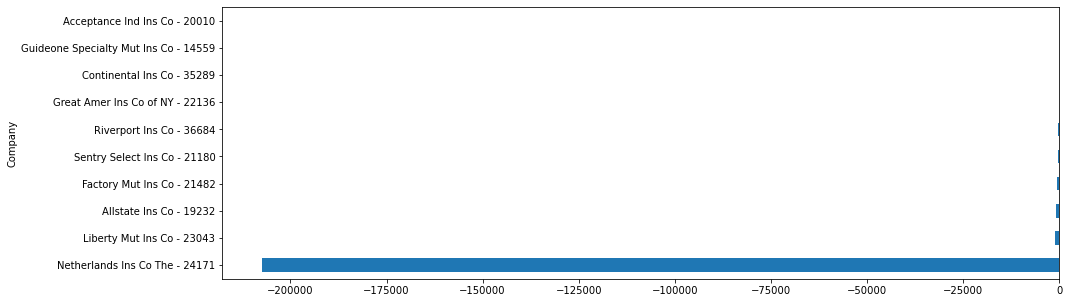

In [113]:
plt.figure(figsize=(15,5))
negative_loss.groupby('Company')['Loss Ratio'].sum().sort_values()[:10].plot(kind='barh');

In [121]:
negative_loss['Company']=[x[0] for x in negative_loss['Company'].str.split('-')]

In [ ]:
plt.plot()

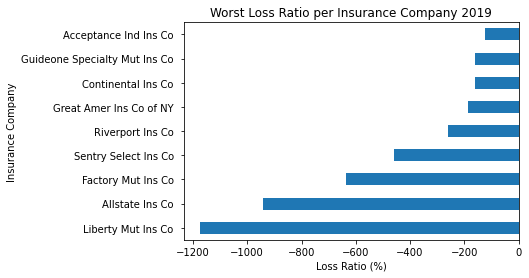

In [130]:
negative_loss.groupby('Company')['Loss Ratio'].sum().sort_values()[1:10].plot(kind='barh');
plt.title("Worst Loss Ratio per Insurance Company 2019")
plt.xlabel('Loss Ratio (%)')
plt.ylabel("Insurance Company");

In [78]:
ca_2019[ca_2019['Loss Ratio'] < 0].sort_values(by='Loss Ratio')

,Company,Written Premium (b),Market Share,Earned Premium (b),Incurred Loss (b),Loss Ratio,Year
154,Netherlands Ins Co The - 24171,210,0.0000%,"2,017",(4181361),-207305.95,2019
131,Liberty Mut Ins Co - 23043,"5,450,668",0.5041%,"3,471,371",(40796702),-1175.23,2019
8,Allstate Ins Co - 19232,"5,925",0.0005%,"6,202",(58384),-941.37,2019
72,Factory Mut Ins Co - 21482,"28,451,305",2.6314%,"24,884,738",(158462041),-636.78,2019
181,Sentry Select Ins Co - 21180,"444,171",0.0411%,"501,317",(2293620),-457.52,2019
174,Riverport Ins Co - 36684,"5,098",0.0005%,"4,988",(13014),-260.91,2019
102,Great Amer Ins Co of NY - 22136,"88,935",0.0082%,"400,326",(753523),-188.23,2019
55,Continental Ins Co - 35289,"585,254",0.0541%,"275,749",(445604),-161.60,2019
108,Guideone Specialty Mut Ins Co - 14559,"221,328",0.0205%,"231,862",(372729),-160.75,2019
0,Acceptance Ind Ins Co - 20010,150,0.0000%,157,(196),-124.84,2019


In [26]:
target = ca_fire_ins_costs.groupby('Year')['Loss Ratio'].sum()

In [27]:
target.index = pd.to_datetime(target.index,format = "%Y")

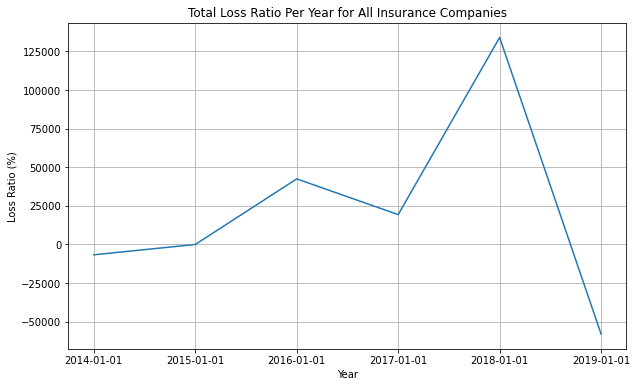

In [134]:
target.plot(figsize=(10,6))
plt.grid()
plt.title('Total Loss Ratio Per Year for All Insurance Companies')
plt.xlabel("Year")
plt.ylabel("Loss Ratio (%)");

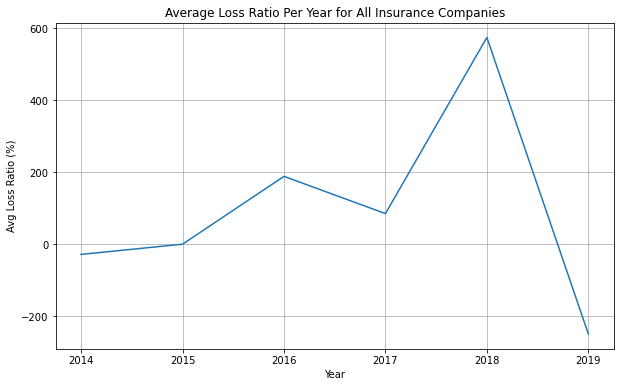

In [136]:
ca_fire_ins_costs.groupby('Year')['Loss Ratio'].mean().plot(figsize=(10,6))
plt.grid()
plt.title('Average Loss Ratio Per Year for All Insurance Companies')
plt.xlabel("Year")
plt.ylabel("Avg Loss Ratio (%)");

In [30]:
# This needs to be run through regex before we can aggregate

# ca_fire_ins_costs.groupby('Year')[' Incurred Loss (b) '].mean()

In [31]:
ca_gdp.rename(columns={'CARGSP':'gdp'},inplace=True)

In [32]:
ca_household_income.rename(columns={'MEHOINUSCAA646N':"median_houshold_income"},inplace=True)

In [33]:
ca_combined = ca_household_income.merge(ca_gdp,on='DATE',how='left')

In [34]:
ca_homeownership.rename(columns={'CAHOWN':'homeownership_pct'},inplace=True)

In [35]:
ca_combined = ca_combined.merge(ca_homeownership,on='DATE',how='left')

In [36]:
ca_combined

,DATE,median_houshold_income,gdp,homeownership_pct
0,1984-01-01,25287,NaN,53.7
1,1985-01-01,26981,NaN,54.2
2,1986-01-01,29010,NaN,53.8
3,1987-01-01,30146,NaN,54.3
4,1988-01-01,30287,NaN,54.4
5,1989-01-01,33009,NaN,53.6
6,1990-01-01,33290,NaN,53.8
7,1991-01-01,33664,NaN,54.5
8,1992-01-01,34903,NaN,55.3
9,1993-01-01,34073,NaN,56.0


In [37]:
ca_rental_vacancies.rename(columns={'CARVAC':'rental_vacancies'},inplace=True)

In [38]:
ca_combined = ca_combined.merge(ca_rental_vacancies,on='DATE',how='left')

In [39]:
ca_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 0 to 35
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DATE                    36 non-null     object 
 1   median_houshold_income  36 non-null     int64  
 2   gdp                     23 non-null     float64
 3   homeownership_pct       36 non-null     float64
 4   rental_vacancies        34 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1.7+ KB


In [40]:
ca_county_tax_rev_per_capita.dropna(inplace=True)

In [41]:
ca_per_cap_personal_income

,DATE,ca_per_cap_inc,%_change_ca,USA_per_cap_inc,%_change-USA,ca_%_of_USA
0,1984-01-01,15895,0.09,13906,0.10,1.14
1,1985-01-01,16795,0.06,14755,0.06,1.14
2,1986-01-01,17588,0.05,15490,0.05,1.14
3,1987-01-01,18482,0.05,16289,0.05,1.13
4,1988-01-01,19605,0.06,17455,0.07,1.12
5,1989-01-01,20561,0.05,18676,0.07,1.10
6,1990-01-01,21485,0.04,19621,0.05,1.10
7,1991-01-01,21857,0.02,20030,0.02,1.09
8,1992-01-01,22678,0.04,21090,0.05,1.08
9,1993-01-01,23013,0.01,21733,0.03,1.06


In [42]:
ca_combined = ca_combined.merge(ca_per_cap_personal_income,on='DATE',how='left')

In [43]:
ca_combined.to_csv('jerry_data/combined_ca_annual.csv',index=False)

In [44]:
ca_state_property_tax.T

,0,1,2,3,4,5,6
assessment_agency_and_type_of_property,Land,Improvements,Real property totals,Tangible personal property,Gross tangible property totals,"Net of ""all other exemptions"" b/",Net of all exemptions
2017-2018,2613741536000,3210576331000,5824317867000,215551129000,6039868996000,5839932017000,5804689067000
2016-2017,2444437742000,3031955786000,5476393528000,213026752000,5689420280000,5499696494000,5463988950000
2015-2016,2308106648000,2882635609000,5190742257000,206355413000,5397097670000,5215173280000,5179173449000
2014-2015,2172253851000,2725742210000,4897996061000,196401461000,5094397522000,4919158715000,4882828822000
2013-2014,2033100408000,2580676544000,4613776952000,188497484000,4802274436000,4636211948000,4599363470000
2012-2013,1939403893000,2475311555000,4414715449000,185530241000,4600245690000,4444104156000,4406587107000
2011-2012,1914015471000,2435006049000,4349021520000,183839781000,4532861301000,4382477939000,4344340278000
2010-2011,1902184206000,2422397382000,4324581588000,186432470000,4511014058000,4370748767000,4332171876000
2009-2010,1937054990000,2451198393000,4388253383000,197054348000,4585307731000,4448943958000,4410239818000


---

#### Quarterly

In [45]:
df_all_wages = pd.read_csv('./jerry_data/CAWTOT.csv')

In [46]:
df_all_wages

,DATE,CAWTOT
0,1998-01-01,5.057518e+08
1,1998-04-01,5.094656e+08
2,1998-07-01,5.210804e+08
3,1998-10-01,5.340726e+08
4,1999-01-01,5.466781e+08
...,...,...
85,2019-04-01,1.328852e+09
86,2019-07-01,1.328657e+09
87,2019-10-01,1.359448e+09
88,2020-01-01,1.380041e+09


In [47]:
df_construction_wages = pd.read_csv('./jerry_data/CAWCON.csv')

In [48]:
df_hospitality_wages = pd.read_csv('./jerry_data/CAWACC.csv')

In [49]:
df_realestate_wages = pd.read_csv('./jerry_data/CAWREA.csv')

In [50]:
df_houseprice_index = pd.read_csv('./jerry_data/CASTHPI.csv')

##### Merge into one data frame

---

#### Monthly

In [51]:
df_unemployment = pd.read_csv('./jerry_data/CAUR.csv')

In [52]:
df_unemployment.describe()

,CAUR
count,537.000000
mean,7.241713
std,2.159086
min,3.900000
25%,5.500000
50%,6.800000
75%,8.600000
max,16.400000


In [53]:
df_building_permits = pd.read_csv('./jerry_data/CABPPRIVSA.csv')

In [54]:
df_building_permits

,DATE,CABPPRIVSA
0,1988-01-01,16466.483109
1,1988-02-01,19704.378621
2,1988-03-01,19420.945694
3,1988-04-01,21148.677854
4,1988-05-01,19129.807991
...,...,...
387,2020-04-01,6047.138500
388,2020-05-01,6342.133603
389,2020-06-01,7634.535211
390,2020-07-01,10344.315562


In [55]:
df_winery_ppi = pd.read_csv('./jerry_data/PCU3121331213.csv')

In [56]:
df_winery_ppi

,DATE,PCU3121331213
0,2003-12-01,100.0
1,2004-01-01,99.9
2,2004-02-01,99.9
3,2004-03-01,100.5
4,2004-04-01,100.3
...,...,...
197,2020-05-01,128.2
198,2020-06-01,128.9
199,2020-07-01,129.0
200,2020-08-01,129.0


In [57]:
ca_unemp_claims = pd.read_csv('./jerry_data/CAICLAIMS.csv')

In [58]:
ca_unemp_claims

,DATE,CAICLAIMS
0,1986-02-01,66360.000000000000
1,1986-03-01,65569.400000000000
2,1986-04-01,53950.000000000000
3,1986-05-01,48693.800000000000
4,1986-06-01,53307.000000000000
...,...,...
412,2020-06-01,264779.000000000000
413,2020-07-01,270988.000000000000
414,2020-08-01,206277.000000000000
415,2020-09-01,216701.750000000000


##### Merge into one dataframe

---

#### Export original dataframes before further pre-processing

In [59]:
data = pd.read_csv('jerry_data/combined_ca_annual.csv')

In [60]:
data.dropna(inplace=True)

In [70]:
target.index=target.index.astype(str)

In [71]:
target

Year
2014-01-01     -6676.510000
2015-01-01        12.294063
2016-01-01     42463.130000
2017-01-01     19343.380000
2018-01-01    133978.060000
2019-01-01    -57908.700000
Name: Loss Ratio, dtype: float64

In [64]:
data.rename(columns={'DATE':'Year'},inplace=True)

In [65]:
full = data.merge(target,on='Year',how='left')

In [66]:
full.set_index('Year')

,median_houshold_income,gdp,homeownership_pct,rental_vacancies,ca_per_cap_inc,%_change_ca,USA_per_cap_inc,%_change-USA,ca_%_of_USA,Loss Ratio
Year,,,,,,,,,,
1997-01-01,39694,1379722.1,55.7,6.5,27171,0.05,25993,0.05,1.05,NaN
1998-01-01,40934,1470543.0,56.0,6.0,29100,0.07,27557,0.06,1.06,NaN
1999-01-01,43629,1583231.3,55.7,5.0,30640,0.05,28675,0.04,1.07,NaN
2000-01-01,46816,1709490.6,57.1,4.5,33364,0.09,30657,0.07,1.09,NaN
2001-01-01,47262,1707064.7,58.2,4.2,34043,0.02,31589,0.03,1.08,NaN
2002-01-01,47437,1747199.5,57.7,5.0,34214,0.01,31832,0.01,1.07,NaN
2003-01-01,49300,1829296.5,58.9,5.4,35415,0.04,32681,0.03,1.08,NaN
2004-01-01,49222,1902550.4,59.7,5.4,37369,0.06,34251,0.05,1.09,NaN
2005-01-01,51755,1988736.5,59.7,6.0,39279,0.05,35849,0.05,1.10,NaN


---

In [69]:
full

,Year,median_houshold_income,gdp,homeownership_pct,rental_vacancies,ca_per_cap_inc,%_change_ca,USA_per_cap_inc,%_change-USA,ca_%_of_USA,Loss Ratio
0,1997-01-01,39694,1379722.1,55.7,6.5,27171,0.05,25993,0.05,1.05,NaN
1,1998-01-01,40934,1470543.0,56.0,6.0,29100,0.07,27557,0.06,1.06,NaN
2,1999-01-01,43629,1583231.3,55.7,5.0,30640,0.05,28675,0.04,1.07,NaN
3,2000-01-01,46816,1709490.6,57.1,4.5,33364,0.09,30657,0.07,1.09,NaN
4,2001-01-01,47262,1707064.7,58.2,4.2,34043,0.02,31589,0.03,1.08,NaN
5,2002-01-01,47437,1747199.5,57.7,5.0,34214,0.01,31832,0.01,1.07,NaN
6,2003-01-01,49300,1829296.5,58.9,5.4,35415,0.04,32681,0.03,1.08,NaN
7,2004-01-01,49222,1902550.4,59.7,5.4,37369,0.06,34251,0.05,1.09,NaN
8,2005-01-01,51755,1988736.5,59.7,6.0,39279,0.05,35849,0.05,1.10,NaN
9,2006-01-01,55319,2072274.1,60.2,5.8,42088,0.07,38114,0.06,1.10,NaN


### VISUALIZATIONS

<br>

### MODEL PREPERATION


#### Train / Test / Split data for modeling

<br>

### MODELING

#### Model #1 - Baseline

#### Model #2 - Naive Bayes

#### Model #3 - Logistic Regression

<br>

### CONCLUSIONS & RECOMMENDATIONS